In [1]:
import numpy as np
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
#@title
def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    # def x_direct(a):
    #     if a in [0, 2, 4, 5]:
    #         return 0
    #     return 1 if a == 1 else -1
    # def y_direct(a):
    #     if a in [1, 3]:
    #         return 0
    #     return 1 if (a == 0 or a == 4) else -1
    # policy = Q.argmax(-1)
    # policyx = np.vectorize(x_direct)(policy)
    # policyy = np.vectorize(y_direct)(policy)
    # idx = np.indices(policy.shape)
    # plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    # plt.show()

def plot_visits(visits, message = "Average visits to each state"):
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(visits, edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.show()

In [3]:
env=gym.make('Taxi-v3')
env.reset()
state_shape = env.observation_space.n 
action_shape = env.action_space.n
no_of_actions = env.action_space.n

#Current State
print(env.s)
print(env.action_space)

# 4x12 grid = 48 states
print ("Number of states:", env.nS)

# Primitive Actions
action = ["up", "right", "down", "left"]
#correspond to [0,1,2,3] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

267
Discrete(6)
Number of states: 500
Number of actions that an agent can take: 6
Action taken: right
Transition probability: {'prob': 1.0}
Next state: 167
Reward recieved: -1
Terminal state: False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


In [4]:
# We are defining options here
# Option 1 ["go_red"] - > Go to RED
# Option 2 ["go_yellow"] - > Go to YELLOW
# Option 3 ["go_green"] - > Go to GREEN
# Option 4 ["go_blue"] - > Go to BLUE

def go_red(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[1, 3, 0, 3, 3], [1, 3, 0, 3, 3], [1, 3, 3, 3, 3], [1, 1, 3, 1, 3], [1, 1, 3, 1, 3]]
  if r == 0 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_yellow(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 3, 0, 0, 0], [0, 3, 0, 3, 3], [0, 3, 3, 3, 3], [0, 1, 3, 1, 3], [0, 1, 3, 1, 3]]
  if r == 4 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_green(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[2, 0, 2, 2, 2], [2, 0, 2, 2, 1], [2, 2, 2, 2, 1], [1, 2, 1, 2, 1], [1, 2, 1, 2, 1]]
  if r == 0 and c == 4: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

def go_blue(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[2, 0, 2, 0, 3], [2, 0, 2, 0, 3], [2, 2, 2, 0, 3], [1, 2, 1, 0, 3], [1, 2, 1, 0, 3]]
  if r == 4 and c == 3: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

'''
Now the new action space will contain
["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]
Corresponding to [0, 1, 2, 3, 4, 5]
'''

'\nNow the new action space will contain\n["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]\nCorresponding to [0, 1, 2, 3, 4, 5]\n'

In [5]:
rg = np.random.RandomState(42)

# Epsilon-greedy action selection function
def egreedy_policy(Q, state, epsilon):
  if not Q[state].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
  else:
        return np.argmax(Q[state])

## SMDP Q-learning

In [18]:
def SMDP_learning(env, q_values_SMDP, q_updates_SMDP, gamma, alpha, epsilon, episodes):
  rewards_SMDP=[]
  for _ in range(episodes):
      state = env.reset()    
      done = False
      r = 0
      # While episode is not over
      while not done:
          # Choose action        
          action = egreedy_policy(q_values_SMDP, state, epsilon=0.1)
          
          # Checking if primitive action
          if action < 6:
              # Perform regular Q-Learning update for state-action pair
              n_state, rew, done, _ = env.step(action)
              q_values_SMDP[state, action] = q_values_SMDP[state, action] + alpha*(rew + gamma*np.max(q_values_SMDP[n_state, :]) - q_values_SMDP[state, action])
              q_updates_SMDP[state, action] += 1
              state = n_state
              r += rew
              continue
          # Checking if action chosen is an option
          rew_bar = 0
          if action == 6: # action => Red option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_red(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              # Remember SMDP Updates. When & What do you update?  
              continue 
          if action == 7: # action => Yellow option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_yellow(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              continue
          if action == 8: # action => Green option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_green(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              continue
          if action == 9: # action => Blue option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_blue(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              continue
      rewards_SMDP.append(r)
  return q_values_SMDP, q_updates_SMDP, rewards_SMDP

In [19]:
gamma = 0.90
alpha = 0.9
epsilon = 0.1
episodes = 2000
n_runs = 10

rewards_SMDP = []
Q_SMDP = []
Q_updates_SMDP = []

for n in range(n_runs):
  q_values_SMDP = np.zeros((state_shape, action_shape))
  q_updates_SMDP = np.zeros((state_shape, action_shape))
  q_values_SMDP, q_updates_SMDP, rewards = SMDP_learning(env, q_values_SMDP, q_updates_SMDP, gamma, alpha, epsilon, episodes)
  Q_SMDP.append(q_values_SMDP)
  Q_updates_SMDP.append(q_updates_SMDP)
  rewards_SMDP.append(rewards)

Text(0.5, 1.0, 'Reward Curve - Intra Option Q-learning')

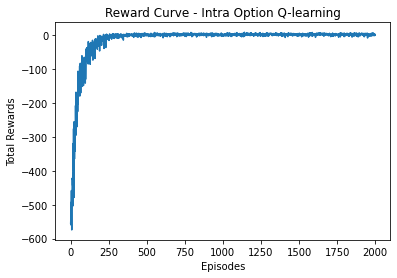

In [20]:
plt.plot(np.average(rewards_SMDP, 0))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Reward Curve - Intra Option Q-learning')

In [21]:
avg_reward_list_SMDP = []
idx = -1
reward_list = np.average(rewards_SMDP, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list_SMDP.append(temp) 

Text(0.5, 1.0, 'Running average of previous 100 rewards')

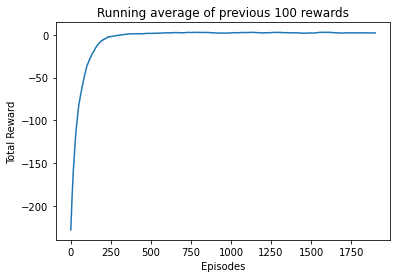

In [22]:
### Plot of total reward vs episode

plt.plot(avg_reward_list_SMDP)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')

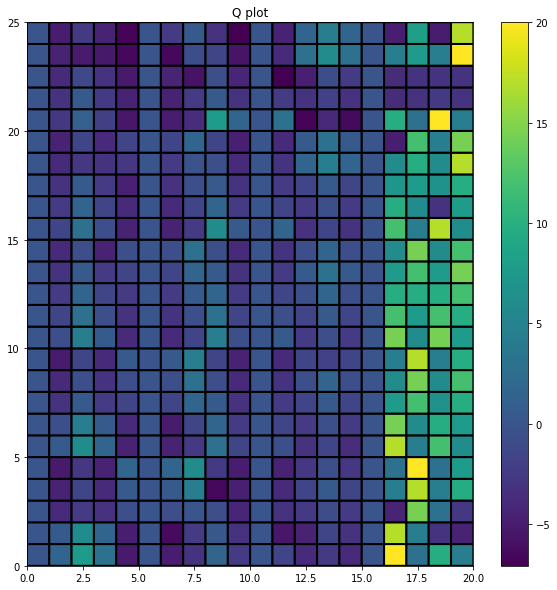

In [ ]:
plot_Q(Q_SMDP[-1].reshape((25, 20, 6)))

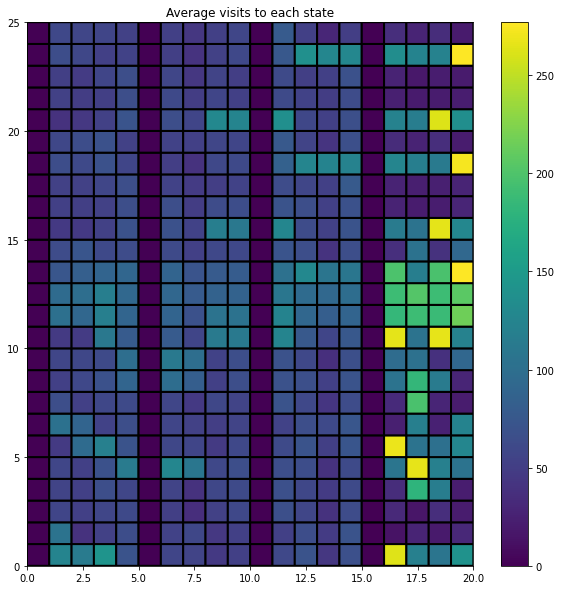

In [ ]:
plot_visits(np.sum(Q_updates_SMDP[-1], axis = -1).reshape((25, 20)))

## Another Set of Options

In [ ]:
# We are defining options here
# Option 1 ["go_red2"] - > Go to RED
# Option 2 ["go_yellow2"] - > Go to YELLOW
# Option 3 ["go_green2"] - > Go to GREEN
# Option 4 ["go_blue2"] - > Go to BLUE

def go_red2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[1, 3, 0, 0, 0], [1, 3, 0, 0, 0], [1, 3, 3, 3, 3], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
  if r == 0 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_yellow2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 3, 3, 3, 3], [0, 1, 1, 1, 1], [0, 1, 1, 1, 1]]
  if r == 4 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_green2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 0, 2, 2, 2], [0, 0, 2, 2, 1], [2, 2, 2, 2, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
  if r == 0 and c == 4: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

def go_blue2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 2, 2, 0, 3], [1, 1, 1, 0, 3], [1, 1, 1, 0, 3]]
  if r == 4 and c == 3: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

'''
Now the new action space will contain
["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]
Corresponding to [0, 1, 2, 3, 4, 5]
'''

'\nNow the new action space will contain\n["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]\nCorresponding to [0, 1, 2, 3, 4, 5]\n'

In [ ]:
def SMDP_learning2(env, q_values_SMDP, q_updates_SMDP, gamma, alpha, epsilon, episodes):
  rewards_SMDP=[]
  for _ in range(1000):
      state = env.reset()    
      done = False
      r = 0
      # While episode is not over
      while not done:
          # Choose action        
          action = egreedy_policy(q_values_SMDP, state, epsilon=0.1)
          
          # Checking if primitive action
          if action < 6:
              # Perform regular Q-Learning update for state-action pair
              n_state, rew, done, _ = env.step(action)
              q_values_SMDP[state, action] = q_values_SMDP[state, action] + alpha*(rew + gamma*np.max(q_values_SMDP[n_state, :]) - q_values_SMDP[state, action])
              q_updates_SMDP[state, action] += 1
              state = n_state
              r += rew
              continue
          # Checking if action chosen is an option
          rew_bar = 0
          if action == 6: # action => Red option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_red2(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              # Remember SMDP Updates. When & What do you update?  
              continue 
          if action == 7: # action => Yellow option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_yellow2(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              continue
          if action == 8: # action => Green option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_green2(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              continue
          if action == 9: # action => Blue option
              curr_state = state
              opdone = False
              n = 1
              while (opdone == False):
                  # Think about what this function might do?
                  opact, opdone = go_blue2(env, state) 
                  n_state, rew, done,_ = env.step(opact)
                  
                  # Is this formulation right? What is this term?
                  rew_bar = rew_bar + (gamma**(n - 1))*rew
                  n += 1
                  state = n_state
                  r += rew
              # Complete SMDP Q-Learning Update
              q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(rew_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
              q_updates_SMDP[curr_state, action] += 1
              continue
      rewards_SMDP.append(r)
  return q_values_SMDP, q_updates_SMDP, rewards_SMDP

In [ ]:
gamma = 0.90
alpha = 0.9
epsilon = 0.1
episodes = 2000
n_runs = 10

rewards_SMDP = []
Q_SMDP = []
Q_updates_SMDP = []

for n in range(n_runs):
  q_values_SMDP = np.zeros((state_shape, action_shape))
  q_updates_SMDP = np.zeros((state_shape, action_shape))
  q_values_SMDP, q_updates_SMDP, rewards = SMDP_learning2(env, q_values_SMDP, q_updates_SMDP, gamma, alpha, epsilon, episodes)
  Q_SMDP.append(q_values_SMDP)
  Q_updates_SMDP.append(q_updates_SMDP)
  rewards_SMDP.append(rewards)

Text(0.5, 1.0, 'Reward Curve - Intra Option Q-learning')

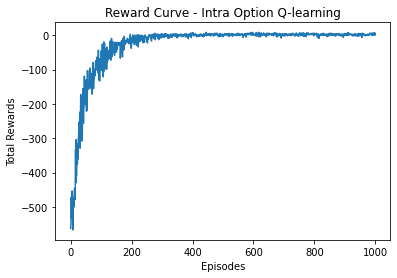

In [ ]:
plt.plot(np.average(rewards_SMDP, 0))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Reward Curve - Intra Option Q-learning')

In [ ]:
avg_reward_list_SMDP = []
idx = -1
reward_list = np.average(rewards_SMDP, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list_SMDP.append(temp) 

Text(0.5, 1.0, 'Running average of previous 100 rewards')

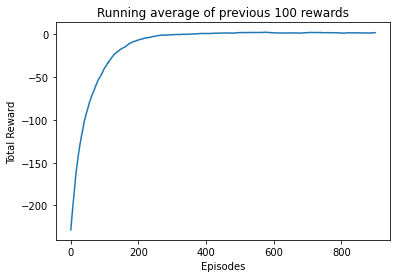

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list_SMDP)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')

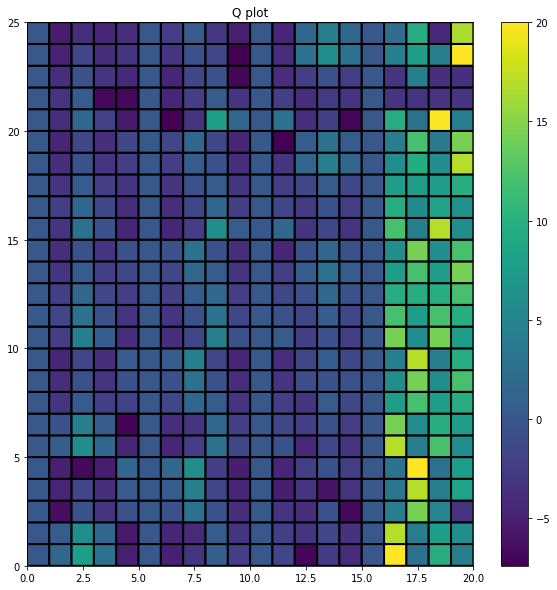

In [ ]:
plot_Q(Q_SMDP[-1].reshape((25, 20, 6)))

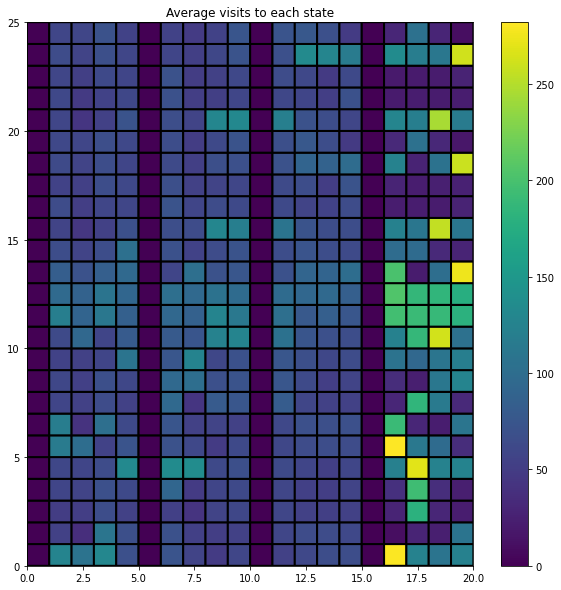

In [ ]:
plot_visits(np.sum(Q_updates_SMDP[-1], axis = -1).reshape((25, 20)))

## Intra-option Q-learning

In [ ]:
import numpy as np
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
#@title
def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    # def x_direct(a):
    #     if a in [0, 2, 4, 5]:
    #         return 0
    #     return 1 if a == 1 else -1
    # def y_direct(a):
    #     if a in [1, 3]:
    #         return 0
    #     return 1 if (a == 0 or a == 4) else -1
    # policy = Q.argmax(-1)
    # policyx = np.vectorize(x_direct)(policy)
    # policyy = np.vectorize(y_direct)(policy)
    # idx = np.indices(policy.shape)
    # plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    # plt.show()

def plot_visits(visits, message = "Average visits to each state"):
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(visits, edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.show()

In [ ]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
env = gym.make('Taxi-v3')
env.seed(0)

state_shape = env.observation_space.n 
action_shape = env.action_space.n
no_of_actions = env.action_space.n
"0: south; 1: north; 2: east; 3: west; 4: pick passenger up; and 5: drop passenger off"

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(list(env.decode(state)))
print("----")

action = env.action_space.sample()  

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(list(env.decode(next_state)))
print(reward)
print(done)
print(info)
print("----")

500
6
5
----
[0, 1, 1, 2]
----
1
----
[0, 1, 1, 2]
-1
False
{'prob': 1.0}
----


In [ ]:
s = env.reset()
print(s)
env.render()

312
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
"0: south; 1: north; 2: east; 3: west; 4: pick passenger up; and 5: drop passenger off"
next_state, reward, done, info = env.step(3)
env.render() 
print(next_state)
print(list(env.decode(next_state)))
print(reward)
print(done)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
312
[3, 0, 3, 0]
-1
False


## Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [ ]:
# We are defining options here
# Option 1 ["go_red"] - > Go to RED
# Option 2 ["go_yellow"] - > Go to YELLOW
# Option 3 ["go_green"] - > Go to GREEN
# Option 4 ["go_blue"] - > Go to BLUE

def go_red(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[1, 3, 0, 3, 3], [1, 3, 0, 3, 3], [1, 3, 3, 3, 3], [1, 1, 3, 1, 3], [1, 1, 3, 1, 3]]
  if r == 0 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_yellow(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 3, 0, 0, 0], [0, 3, 0, 3, 3], [0, 3, 3, 3, 3], [0, 1, 3, 1, 3], [0, 1, 3, 1, 3]]
  if r == 4 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_green(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[2, 0, 2, 2, 2], [2, 0, 2, 2, 1], [2, 2, 2, 2, 1], [1, 2, 1, 2, 1], [1, 2, 1, 2, 1]]
  if r == 0 and c == 4: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

def go_blue(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[2, 0, 2, 0, 3], [2, 0, 2, 0, 3], [2, 2, 2, 0, 3], [1, 2, 1, 0, 3], [1, 2, 1, 0, 3]]
  if r == 4 and c == 3: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

'''
Now the new action space will contain
["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]
Corresponding to [0, 1, 2, 3, 4, 5]
'''

'\nNow the new action space will contain\n["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]\nCorresponding to [0, 1, 2, 3, 4, 5]\n'

## Intra-option Q-learning

In [ ]:
rg = np.random.RandomState(42)

# Epsilon-greedy action selection function
def egreedy_policy(Q, state, epsilon):
  if not Q[state].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
  else:
        return np.argmax(Q[state])

In [ ]:
def IO_learning(env, q_values_IO, q_updates_IO, gamma, alpha, epsilon, episodes):
  rewards_IO = []
  # Iterate over episodes
  for ep in range(episodes):
    state = env.reset()    
    done = False
    r = 0
    # While episode is not over
    while not done:
      action = egreedy_policy(q_values_IO, state, epsilon = epsilon)
        
      # Checking if primitive action
      if action > 3:
        next_state, reward, done, _ = env.step(action)
        q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
        q_updates_IO[state, action] += 1
        state = next_state
        r += reward
        continue
        # Checking if action chosen is an option
      if action == 0: # action => RED option
        optdone = False
        while (optdone == False):
          optact, optdone = go_red(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 0 and c == 0:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue 
      if action == 1:
        optdone = False
        while (optdone == False): # action => GREEN option
          optact, optdone = go_green(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 0 and c == 4:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue
      if action == 2: # action => YELLOW option
        optdone = False
        while (optdone == False):
          optact, optdone = go_yellow(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 4 and c == 0:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue
      if action == 3: # action => BLUE option
        optdone = False
        while (optdone == False):
          optact, optdone = go_blue(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 4 and c == 3:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue
    rewards_IO.append(r)
  return q_values_IO, q_updates_IO, rewards_IO

In [ ]:
#### Intra-Option Q-Learning 

# Divergence when alpha > 1.2

# Hyperparameters 
gamma = 0.90
alpha = 0.9
epsilon = 0.1
episodes = 2000
n_runs = 10

rewards_IO = []
Q_IO = []
Q_updates_IO = []

for n in range(n_runs):
  q_values_IO = np.zeros((state_shape, action_shape))
  q_updates_IO = np.zeros((state_shape, action_shape))
  q_values_IO, q_updates_IO, rewards = IO_learning(env, q_values_IO, q_updates_IO, gamma, alpha, epsilon, episodes)
  Q_IO.append(q_values_IO)
  Q_updates_IO.append(q_updates_IO)
  rewards_IO.append(rewards)

# Q-Tables and Update Frequencies

Text(0.5, 1.0, 'Reward Curve - Intra Option Q-learning')

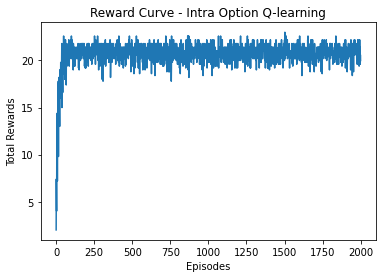

In [ ]:
plt.plot(np.average(rewards_IO, 0))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Reward Curve - Intra Option Q-learning')

In [ ]:
avg_reward_list = []
idx = -1
reward_list = np.average(rewards_IO, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list.append(temp) 

Text(0.5, 1.0, 'Running average of previous 100 rewards')

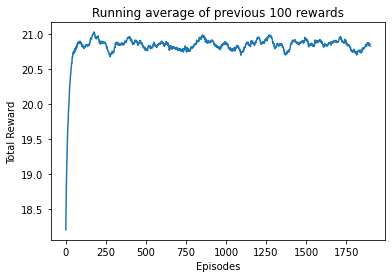

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')

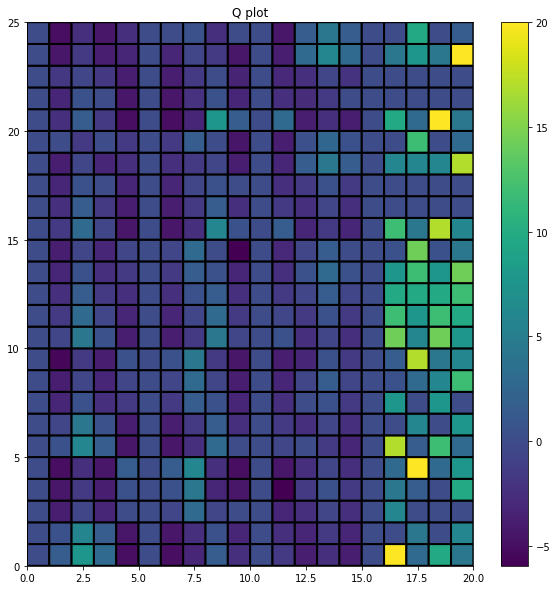

In [ ]:
plot_Q(Q_IO[-1].reshape((25, 20, 6)))

In [ ]:
list(env.decode(479)) # 16, 97, 418, 479

[4, 3, 4, 3]

In [ ]:
Q_IO[-1][479]

array([-3.14409118, -0.1359871 , -3.14645781, 16.9821    ,  7.9999983 ,
       20.        ])

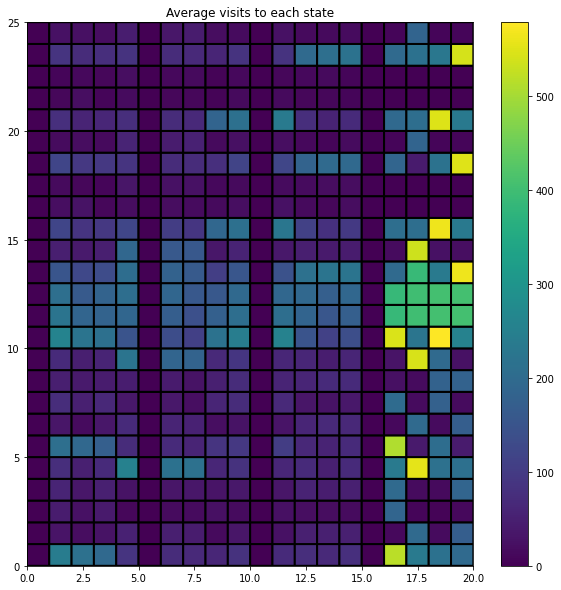

In [ ]:
plot_visits(np.sum(Q_updates_IO[-1], axis = -1).reshape((25, 20)))

## Another set of Options

In [ ]:
# We are defining options here
# Option 1 ["go_red2"] - > Go to RED
# Option 2 ["go_yellow2"] - > Go to YELLOW
# Option 3 ["go_green2"] - > Go to GREEN
# Option 4 ["go_blue2"] - > Go to BLUE

def go_red2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[1, 3, 0, 0, 0], [1, 3, 0, 0, 0], [1, 3, 3, 3, 3], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
  if r == 0 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_yellow2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 3, 3, 3, 3], [0, 1, 1, 1, 1], [0, 1, 1, 1, 1]]
  if r == 4 and c == 0: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]
    
def go_green2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 0, 2, 2, 2], [0, 0, 2, 2, 1], [2, 2, 2, 2, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
  if r == 0 and c == 4: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

def go_blue2(env, state):
  r, c, _, _ = list(env.decode(state))
  optdone = False
  actions = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 2, 2, 0, 3], [1, 1, 1, 0, 3], [1, 1, 1, 0, 3]]
  if r == 4 and c == 3: 
    optdone = True
  optact = actions[r][c]
  return [optact, optdone]

'''
Now the new action space will contain
["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]
Corresponding to [0, 1, 2, 3, 4, 5]
'''

'\nNow the new action space will contain\n["RED", "GREEN", "YELLOW", "BLUE", "pick passenger up", "drop passenger off"]\nCorresponding to [0, 1, 2, 3, 4, 5]\n'

In [ ]:
def IO_learning2(env, q_values_IO, q_updates_IO, gamma, alpha, epsilon, episodes):
  rewards_IO = []
  # Iterate over episodes
  for ep in range(episodes):
    state = env.reset()    
    done = False
    r = 0
    # While episode is not over
    while not done:
      action = egreedy_policy(q_values_IO, state, epsilon = epsilon)
        
      # Checking if primitive action
      if action > 3:
        next_state, reward, done, _ = env.step(action)
        q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
        q_updates_IO[state, action] += 1
        state = next_state
        r += reward
        continue
        # Checking if action chosen is an option
      if action == 0: # action => RED option
        optdone = False
        while (optdone == False):
          optact, optdone = go_red2(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 0 and c == 0:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue 
      if action == 1:
        optdone = False
        while (optdone == False): # action => GREEN option
          optact, optdone = go_green2(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 0 and c == 4:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue
      if action == 2: # action => YELLOW option
        optdone = False
        while (optdone == False):
          optact, optdone = go_yellow2(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 4 and c == 0:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue
      if action == 3: # action => BLUE option
        optdone = False
        while (optdone == False):
          optact, optdone = go_blue2(env, state) 
          next_state, reward, done,_ = env.step(optact)
          r, c, _, _ = list(env.decode(next_state))
          if r == 4 and c == 3:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            optdone = True
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*q_values_IO[next_state, action] - q_values_IO[state, action])
          q_updates_IO[state, action] += 1
          state = next_state
          r += reward  
        continue
    rewards_IO.append(r)
  return q_values_IO, q_updates_IO, rewards_IO

In [ ]:
#### Intra-Option Q-Learning 

# Hyperparameters 
gamma = 0.90
alpha = 0.90
epsilon = 0.1
episodes = 2000
n_runs = 10

rewards_IO = []
Q_IO = []
Q_updates_IO = []

for n in range(n_runs):
  q_values_IO = np.zeros((state_shape, action_shape))
  q_updates_IO = np.zeros((state_shape, action_shape))
  q_values_IO, q_updates_IO, rewards = IO_learning2(env, q_values_IO, q_updates_IO, gamma, alpha, epsilon, episodes)
  Q_IO.append(q_values_IO)
  Q_updates_IO.append(q_updates_IO)
  rewards_IO.append(rewards)

# Q-Tables and Update Frequencies

Text(0.5, 1.0, 'Reward Curve - Intra Option Q-learning')

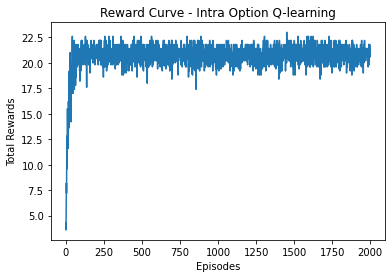

In [ ]:
plt.plot(np.average(rewards_IO, 0))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Reward Curve - Intra Option Q-learning')

In [ ]:
avg_reward_list = []
idx = -1
reward_list = np.average(rewards_IO, 0)
for i in range(len(reward_list) - 99):
  temp = np.mean(reward_list[i:i + 100])
  avg_reward_list.append(temp) 

Text(0.5, 1.0, 'Running average of previous 100 rewards')

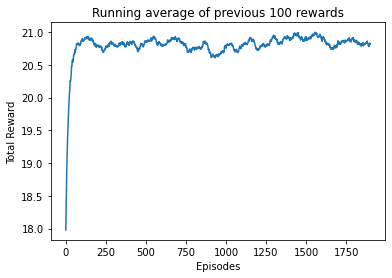

In [ ]:
### Plot of total reward vs episode

plt.plot(avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Running average of previous 100 rewards')

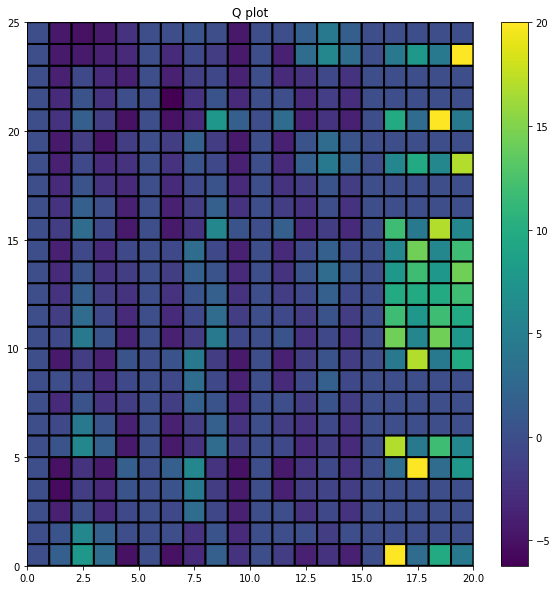

In [ ]:
plot_Q(Q_IO[-1].reshape((25, 20, 6)))

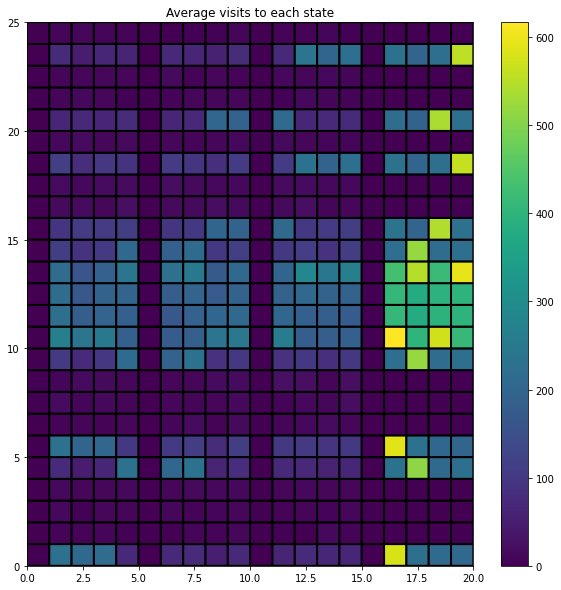

In [ ]:
plot_visits(np.sum(Q_updates_IO[-1], axis = -1).reshape((25, 20)))